In [80]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,\
      mean_squared_log_error, mean_absolute_error, make_scorer, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
import shap
from xgboost import XGBRegressor

In [81]:
data = pd.read_csv('data.csv')

In [82]:
data.set_index('OSEBuildingID', inplace = True)

In [83]:
cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUseWN(kBtu)', 'Age',]

NumberofBuildings
32.32724400559336


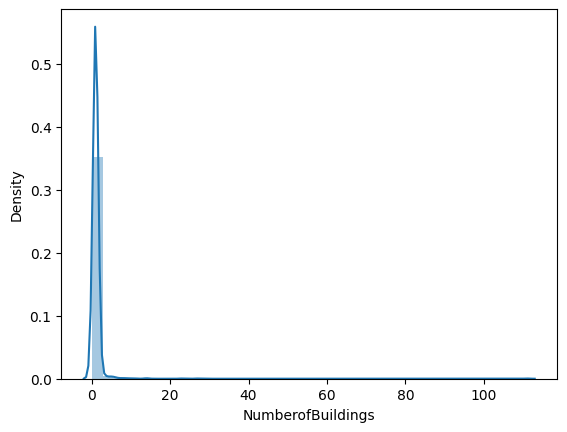

NumberofFloors
6.006854939731992


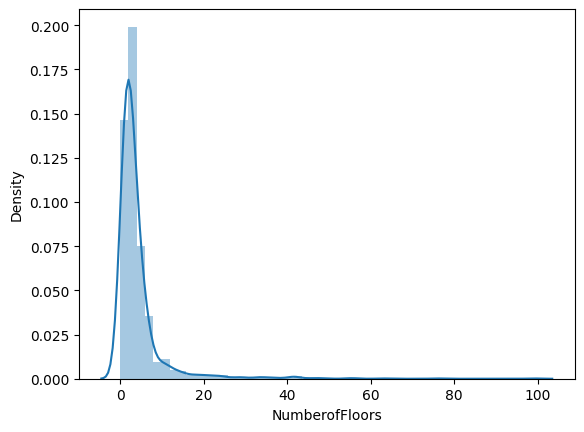

PropertyGFATotal
19.037917545145827


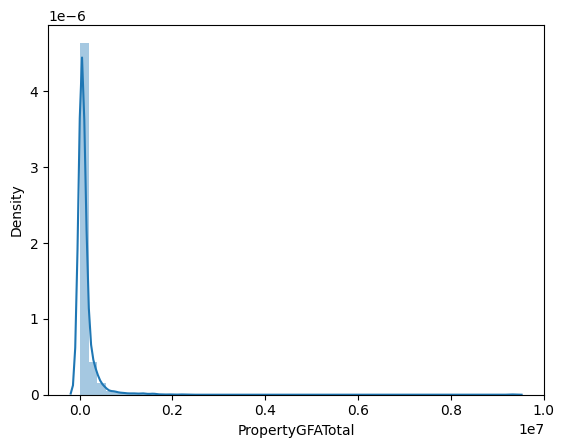

LargestPropertyUseTypeGFA
23.175161728669494


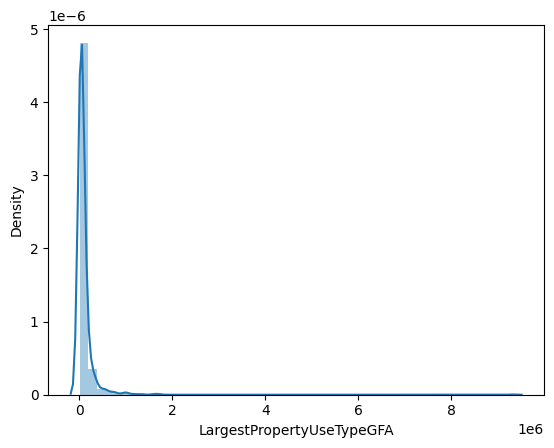

ENERGYSTARScore
0.07727154779048637


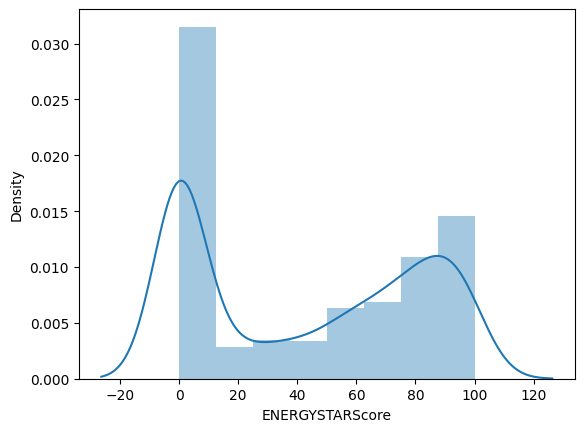

SiteEnergyUseWN(kBtu)
11.278921136571357


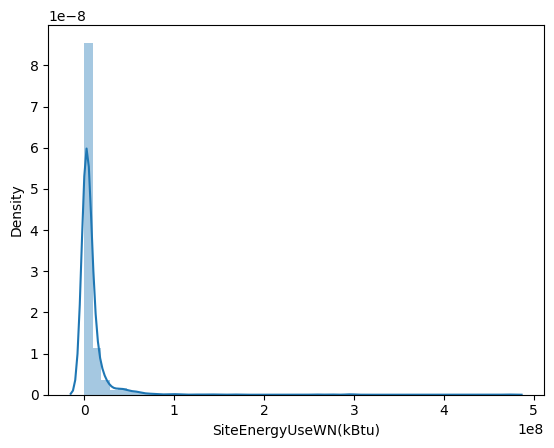

Age
0.29753360879193896


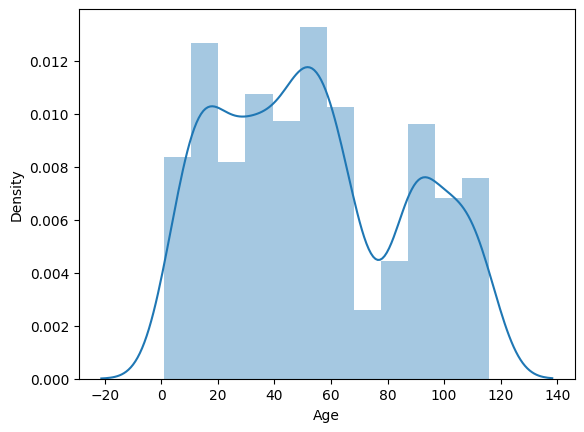

In [84]:
for col in cols:
      print(col)
      print(skew(data[col]))

      plt.figure()
      sns.distplot(data[col])
      plt.show()

<AxesSubplot: >

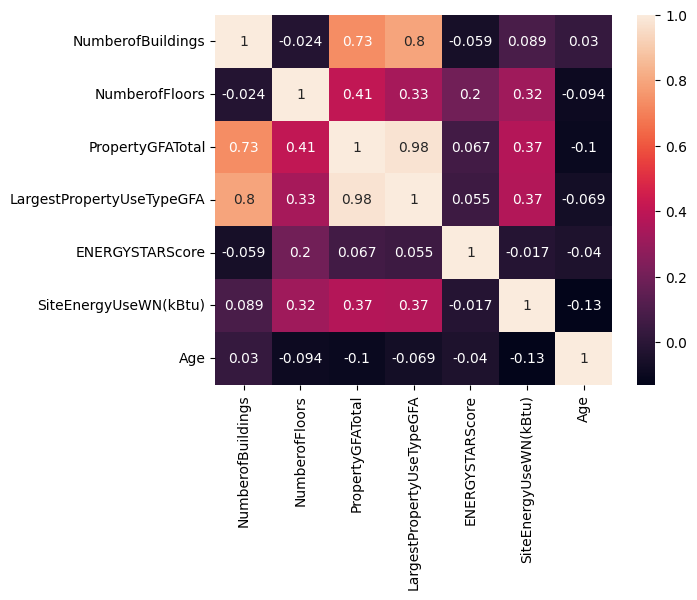

In [85]:
sns.heatmap(data[cols].corr(), annot = True)

In [86]:
data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [87]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal',
        'PropertyGFAParking(%)','PropertyGFABuilding(s)(%)',
        'LargestPropertyUseTypeGFA','ENERGYSTARScore',
        'EnergyStarNaN','PrimaryPropertyType_Distribution Center',
        'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]

y = data['SiteEnergyUseWN(kBtu)']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
colsk = ['NumberofFloors','PropertyGFATotal',
'LargestPropertyUseTypeGFA']
X_train_tt = X_train.copy()
X_test_tt = X_test.copy()
X_train_tt[colsk] = np.log1p(X_train_tt[colsk])
X_test_tt[colsk] = np.log1p(X_test_tt[colsk])

In [90]:
std_scale = StandardScaler()
std_scale.fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
std_scale_tt = StandardScaler()
std_scale_tt.fit(X_train_tt)
X_train_tt = std_scale_tt.transform(X_train_tt)
X_test_tt = std_scale_tt.transform(X_test_tt)

In [91]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)
X_train_tt = pd.DataFrame(X_train_tt, columns = X.columns)
X_test_tt = pd.DataFrame(X_test_tt, columns = X.columns)

In [92]:
dr = DummyRegressor(strategy='mean')
dr.fit(X_train, y_train)
y_pred = dr.predict(X_test)
baseline_error = mean_squared_error(y_test, y_pred, squared=False)
baseline_error

23631064.94693869

In [93]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr_error = mean_squared_error(y_test, y_pred, squared=False)
lr_error

20196432.636125617

In [94]:
def resultize(grid):

    res = pd.DataFrame(grid.cv_results_)
    res = res[['params', 'mean_test_RMSE', 'rank_test_RMSE', 'mean_test_MSE', 'rank_test_MSE', 'mean_test_MAE', 'rank_test_MAE', 'mean_test_R2', 'rank_test_R2']]
    res['mean_test_MSE'] = (-res[f'mean_test_MSE'])
    res['mean_test_RMSE'] = (-res[f'mean_test_RMSE'])
    res['mean_test_MAE'] = (-res[f'mean_test_MAE'])
    res.sort_values(by='rank_test_RMSE', inplace=True)
    return res

In [95]:
s = {'MSE': 'neg_mean_squared_error', 
      'RMSE': 'neg_root_mean_squared_error',
      'MAE': 'neg_mean_absolute_error',
      'R2': 'r2'}
score = 'RMSE'

In [96]:
params = {'alpha': np.logspace(0, 7, 20)}
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, params, cv=10, scoring = s , refit = score, n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge_best_params = grid_ridge.best_params_
resultize(grid_ridge).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
9,{'alpha': 2069.138081114788},1.780335e+07,1,4.191994e+14,1,6.536669e+06,4,0.108530,2
10,{'alpha': 4832.930238571752},1.795162e+07,2,4.240512e+14,2,7.170298e+06,7,0.159311,1
8,{'alpha': 885.8667904100823},1.837939e+07,3,4.546267e+14,4,6.126887e+06,1,-0.227513,12
11,{'alpha': 11288.378916846883},1.844788e+07,4,4.413562e+14,3,7.776601e+06,12,0.107663,3
12,{'alpha': 26366.508987303554},1.888780e+07,5,4.561399e+14,5,8.187544e+06,13,0.049917,4


In [97]:
grid_ridge_best_params = {'alpha': 2069.138081114788}

In [98]:
ridge = Ridge(**grid_ridge_best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_error = mean_squared_error(y_test, y_pred, squared=False)
ridge_error

21695568.8279637

In [99]:
'''params = {'alpha': np.logspace(-3, 10, 200)}
grid_lasso = GridSearchCV(Lasso(), params, cv=10, scoring = s , refit = score, n_jobs=-1)
grid_lasso.fit(X_train, y_train)
grid_lasso_best_params = grid_lasso.best_params_
resultize(grid_lasso).head()'''

"params = {'alpha': np.logspace(-3, 10, 200)}\ngrid_lasso = GridSearchCV(Lasso(), params, cv=10, scoring = s , refit = score, n_jobs=-1)\ngrid_lasso.fit(X_train, y_train)\ngrid_lasso_best_params = grid_lasso.best_params_\nresultize(grid_lasso).head()"

In [100]:
grid_lasso_best_params = {'alpha': 6294988.990221888}

In [101]:
lasso = Lasso(**grid_lasso_best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, y_pred, squared=False)
lasso_error

23144461.077667505

In [102]:
tt_ridge = TransformedTargetRegressor(regressor=Ridge(), 
                                    func=np.log1p, 
                                    inverse_func=np.expm1)
params = {'regressor__alpha': np.logspace(0, 7, 100)}
grid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_ridge.fit(X_train_tt, y_train)
grid_tt_ridge_best_params = grid_tt_ridge.best_params_
resultize(grid_tt_ridge).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
42,{'regressor__alpha': 932.60334688322},1.776230e+07,1,4.192465e+14,1,5.181652e+06,4,0.184437,2
43,{'regressor__alpha': 1097.4987654930555},1.781319e+07,2,4.225908e+14,3,5.251929e+06,6,0.190743,1
41,{'regressor__alpha': 792.482898353917},1.787033e+07,3,4.212820e+14,2,5.125052e+06,3,0.137483,6
44,{'regressor__alpha': 1291.549665014884},1.794422e+07,4,4.279878e+14,4,5.331655e+06,7,0.180167,3
45,{'regressor__alpha': 1519.9110829529332},1.811094e+07,5,4.340973e+14,5,5.415302e+06,8,0.162336,4


In [103]:
grid_tt_ridge_best_params = {'alpha': 932.60334688322}

In [104]:
tt_ridge = TransformedTargetRegressor(
      regressor=Ridge(**grid_tt_ridge_best_params),
      func=np.log1p,
        inverse_func=np.expm1)
tt_ridge.fit(X_train, y_train)
y_pred = tt_ridge.predict(X_test)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

23510286.748396628

In [105]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(-1, 3, 30)}
grid_tt_lasso = GridSearchCV(tt_lasso, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_lasso.fit(X_train, y_train)
grid_tt_lasso_best_params = grid_tt_lasso.best_params_
resultize(grid_tt_lasso).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
4,{'regressor__alpha': 0.3562247890262442},1.953752e+07,1,4.828368e+14,1,6.433659e+06,1,-0.026055,1
5,{'regressor__alpha': 0.4893900918477494},1.994640e+07,2,4.967341e+14,2,6.622218e+06,2,-0.084988,2
14,{'regressor__alpha': 8.531678524172806},2.013129e+07,3,5.029874e+14,3,6.726590e+06,3,-0.113368,3
27,{'regressor__alpha': 529.8316906283708},2.013129e+07,3,5.029874e+14,3,6.726590e+06,3,-0.113368,3
26,{'regressor__alpha': 385.6620421163472},2.013129e+07,3,5.029874e+14,3,6.726590e+06,3,-0.113368,3


In [106]:
grid_tt_lasso_best_params = {'alpha': 0.3562247890262442}

In [107]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(**grid_tt_lasso_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_lasso.fit(X_train, y_train)
y_pred = tt_lasso.predict(X_test)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

24744014.374707863

In [109]:
params = {'kernel': ['sigmoid','rbf','poly'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
grid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,
                        refit = score,  n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_params_svr = grid_svr.best_params_
resultize(grid_svr).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
56,"{'C': 1000, 'degree': 1, 'kernel': 'poly'}",2.005918e+07,1,5.004511e+14,1,6.700392e+06,1,-0.102251,1
66,"{'C': 1000, 'degree': 5, 'kernel': 'sigmoid'}",2.006199e+07,2,5.005458e+14,2,6.703180e+06,2,-0.102685,2
54,"{'C': 1000, 'degree': 1, 'kernel': 'sigmoid'}",2.006199e+07,2,5.005458e+14,2,6.703180e+06,2,-0.102685,2
57,"{'C': 1000, 'degree': 2, 'kernel': 'sigmoid'}",2.006199e+07,2,5.005458e+14,2,6.703180e+06,2,-0.102685,2
69,"{'C': 1000, 'degree': 6, 'kernel': 'sigmoid'}",2.006199e+07,2,5.005458e+14,2,6.703180e+06,2,-0.102685,2


In [110]:
grid_svr_best_params = {'C': 1000, 'degree': 1, 'kernel': 'poly'}

In [111]:
svr = SVR(**grid_svr_best_params)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

24289813.863015983

In [121]:
tt_svr = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__C': [0.1,1,100,1000],
            'regressor__degree': [1,2,3,4,5,6],
            'regressor__kernel': ['sigmoid','rbf','poly']}
grid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_svr.fit(X_train_tt, y_train)
best_params_svr_tt = grid_tt_svr.best_params_
resultize(grid_tt_svr).head()

/home/lolonois/.local/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:301: RuntimeWarning: overflow encountered in expm1
  return func(X, **(kw_args if kw_args else {}))
/home/lolonois/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lolonois/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/lolonois/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/lolonois/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 268, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/lolonois/.loca

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGSEGV(-11)}

In [114]:
best_params_svr_tt

{'regressor__C': 1, 'regressor__degree': 1, 'regressor__kernel': 'rbf'}

In [118]:
best_params_svr_tt = {'C': 1, 'degree': 1, 'kernel': 'rbf'}

In [122]:
tt_svr = TransformedTargetRegressor(regressor = SVR(**best_params_svr_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_svr.fit(X_train_tt, y_train)
y_pred = tt_svr.predict(X_test_tt)
tt_svr_error = mean_squared_error(y_test, y_pred, squared=False)
tt_svr_error

15689145.73469242

In [120]:
params = {'n_estimators': [10, 100, 1000],
            'max_depth': [1, 10, 100, 1000],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]}
grid_rf = GridSearchCV(RandomForestRegressor(), params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_params_rf = grid_rf.best_params_
resultize(grid_rf).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
60,"{'max_depth': 100, 'min_samples_leaf': 1, 'min...",1.422846e+07,1,2.830191e+14,1,4.352701e+06,7,0.429810,1
48,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",1.446814e+07,2,2.904593e+14,2,4.393249e+06,26,0.373150,2
97,"{'max_depth': 1000, 'min_samples_leaf': 2, 'mi...",1.447868e+07,3,2.975228e+14,3,4.299859e+06,2,0.318344,7
76,"{'max_depth': 100, 'min_samples_leaf': 4, 'min...",1.458022e+07,4,3.065194e+14,16,4.360925e+06,11,0.315753,10
46,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",1.458558e+07,5,3.062515e+14,15,4.352729e+06,8,0.310132,12


In [125]:
best_params_rf = {'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 10}

In [126]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

17073129.43375294

In [40]:

tt_rf.fit(X_train_tt, y_train)
y_pred = tt_rf.predict(X_test)
tt_rf_error = mean_squared_error(y_test, y_pred, squared=False)
tt_rf_error

28.651787336994825

In [128]:
'''tt_rf = TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__n_estimators': [10, 100, 1000],
            'regressor__max_depth': [1, 10, 100, 1000],
            'regressor__min_samples_split': [2, 5, 10],    
            'regressor__min_samples_leaf': [1, 2, 4]}
grid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_rf.fit(X_train_tt, y_train)
best_params_rf_tt = grid_tt_rf.best_params_
resultize(grid_tt_rf).head()'''
#1m17s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
60,"{'regressor__max_depth': 100, 'regressor__min_...",1.333148e+07,1,2.761431e+14,1,3.925505e+06,2,0.558365,1
33,"{'regressor__max_depth': 10, 'regressor__min_s...",1.374272e+07,2,2.849993e+14,3,4.045447e+06,22,0.530886,2
81,"{'regressor__max_depth': 1000, 'regressor__min...",1.376622e+07,3,2.816364e+14,2,3.955268e+06,7,0.493227,8
54,"{'regressor__max_depth': 100, 'regressor__min_...",1.384158e+07,4,2.854911e+14,4,4.030675e+06,21,0.504107,3
56,"{'regressor__max_depth': 100, 'regressor__min_...",1.391428e+07,5,2.914545e+14,9,3.916004e+06,1,0.492806,9


In [130]:
best_params_rf_tt = {'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 10}

In [131]:
tt_rf = TransformedTargetRegressor(regressor=RandomForestRegressor(**best_params_rf_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_rf.fit(X_train_tt, y_train)
y_pred = tt_rf.predict(X_test_tt)
tt_rf_error = mean_squared_error(y_test, y_pred, squared=False)
tt_rf_error

16902220.2596693

29.615176026055483

In [132]:
params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9, 17],
}
grid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_params_gb = grid_gb.best_params_
resultize(grid_gb).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
23,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",1.374945e+07,1,2.881199e+14,5,3.769777e+06,3,0.547141,1
52,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",1.376209e+07,2,2.763563e+14,1,3.801065e+06,6,0.494066,14
19,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",1.384460e+07,3,2.910185e+14,6,3.761297e+06,2,0.538192,3
16,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",1.384643e+07,4,2.826695e+14,3,3.770014e+06,4,0.446811,23
20,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",1.386549e+07,5,2.813153e+14,2,3.907331e+06,15,0.454212,21


In [134]:
best_params_gb = {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 17}

In [135]:
gb = GradientBoostingRegressor(**best_params_gb)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

17370504.225065384

In [136]:
'''tt_gb = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train_tt, y_train)
best_params_gb_tt = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()'''
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
18,"{'regressor__learning_rate': 0.1, 'regressor__...",1.344245e+07,1,2.680758e+14,1,3.577778e+06,1,0.533644,1
20,"{'regressor__learning_rate': 0.1, 'regressor__...",1.373864e+07,2,2.763991e+14,4,3.776096e+06,12,0.488851,10
17,"{'regressor__learning_rate': 0.1, 'regressor__...",1.375886e+07,3,2.760334e+14,3,3.684655e+06,2,0.467716,14
19,"{'regressor__learning_rate': 0.1, 'regressor__...",1.379762e+07,4,2.744777e+14,2,3.708101e+06,3,0.507619,6
52,"{'regressor__learning_rate': 0.05, 'regressor_...",1.387457e+07,5,2.826119e+14,6,3.790298e+06,15,0.482786,11


In [138]:
best_params_gb_tt = {'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 4,
 'min_samples_leaf': 9}

In [139]:
tt_gb = TransformedTargetRegressor(regressor=GradientBoostingRegressor(**best_params_gb_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_gb.fit(X_train_tt, y_train)
y_pred = tt_gb.predict(X_test_tt)
tt_gb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error

13281643.114577873

In [140]:
'''ad = AdaBoostRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential'],
}
grid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_ad.fit(X_train, y_train)
best_params_ad = grid_ad.best_params_
resultize(grid_ad).head()'''
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
46,"{'learning_rate': 0.01, 'loss': 'linear', 'n_e...",1.527366e+07,1,3.272779e+14,4,5.117684e+06,6,0.397833,1
55,"{'learning_rate': 0.01, 'loss': 'exponential',...",1.538836e+07,2,3.268980e+14,3,4.939766e+06,1,0.338272,2
45,"{'learning_rate': 0.01, 'loss': 'linear', 'n_e...",1.553053e+07,3,3.316364e+14,8,5.015000e+06,2,0.320947,4
30,"{'learning_rate': 0.02, 'loss': 'linear', 'n_e...",1.559509e+07,4,3.308018e+14,7,5.181805e+06,7,0.324466,3
10,"{'learning_rate': 0.1, 'loss': 'exponential', ...",1.566832e+07,5,3.245326e+14,1,5.999327e+06,37,0.271678,10


In [142]:
best_params_ad = {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 200}

In [143]:
ad = AdaBoostRegressor(**best_params_ad)
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
ad_error = mean_squared_error(y_test, y_pred, squared=False)
ad_error

15227693.240508188

In [144]:
'''tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__loss': ['linear', 'square', 'exponential'],
}
grid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_ad.fit(X_train_tt, y_train)
best_params_ad_tt = grid_tt_ad.best_params_
resultize(grid_tt_ad).head()'''
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
55,"{'regressor__learning_rate': 0.01, 'regressor_...",1.548778e+07,1,3.456215e+14,1,4.684280e+06,1,0.424060,1
45,"{'regressor__learning_rate': 0.01, 'regressor_...",1.593298e+07,2,3.638930e+14,2,4.848677e+06,2,0.387884,2
56,"{'regressor__learning_rate': 0.01, 'regressor_...",1.602880e+07,3,3.684938e+14,4,4.912459e+06,4,0.382011,3
40,"{'regressor__learning_rate': 0.02, 'regressor_...",1.603912e+07,4,3.679105e+14,3,4.907469e+06,3,0.380027,4
50,"{'regressor__learning_rate': 0.01, 'regressor_...",1.609724e+07,5,3.697611e+14,5,4.989059e+06,5,0.374574,5


In [146]:
best_params_ad_tt = {'learning_rate': 0.01,
      'loss': 'exponential',
      'n_estimators': 100}

In [147]:
tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(**best_params_ad_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_ad.fit(X_train_tt, y_train)
y_pred = tt_ad.predict(X_test_tt)
tt_ad_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ad_error

19715220.101583004

In [159]:
"""mlp = MLPRegressor()
params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
}
grid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_params_mlp = grid_mlp.best_params_
resultize(grid_mlp).head()"""
#1m30s

"mlp = MLPRegressor()\nparams = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'solver': ['lbfgs', 'adam'],\n}\ngrid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_mlp.fit(X_train, y_train)\nbest_params_mlp = grid_mlp.best_params_\nresultize(grid_mlp).head()"

In [152]:
best_params_mlp = {'activation': 'logistic', 'hidden_layer_sizes': (500,), 'solver': 'lbfgs'}

In [153]:
mlp = MLPRegressor(**best_params_mlp)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_error = mean_squared_error(y_test, y_pred, squared=False)
mlp_error

21894743.100723073

In [158]:
"""tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'adam'],
}
grid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_mlp.fit(X_train_tt, y_train)
best_params_mlp_tt = grid_tt_mlp.best_params_
resultize(grid_tt_mlp).head()"""
#1m30s

"tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(),\n                                    func=np.log1p,\n                                    inverse_func=np.expm1)\nparams = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'regressor__solver': ['lbfgs', 'adam'],\n}\ngrid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_mlp.fit(X_train_tt, y_train)\nbest_params_mlp_tt = grid_tt_mlp.best_params_\nresultize(grid_tt_mlp).head()"

In [157]:
best_params_mlp_tt = {'activation': 'logistic',
 'hidden_layer_sizes': (500,),
 'solver': 'lbfgs'}

In [160]:
tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(**best_params_mlp_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_mlp.fit(X_train_tt, y_train)
y_pred = tt_mlp.predict(X_test_tt)
tt_mlp_error = mean_squared_error(y_test, y_pred, squared=False)
tt_mlp_error

20394827.549604535

In [161]:
xgb = XGBRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [2, 3, 4, 5, 6]}
grid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_params_xgb = grid_xgb.best_params_
resultize(grid_xgb).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
95,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",1.518106e+07,1,3.290469e+14,7,4.492232e+06,7,0.420948,1
90,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.522547e+07,2,3.304196e+14,8,4.494660e+06,8,0.416658,2
85,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",1.547804e+07,3,3.413616e+14,11,4.542013e+06,11,0.400558,3
96,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",1.568848e+07,4,3.248205e+14,2,4.317723e+06,1,0.186966,8
70,"{'learning_rate': 0.02, 'max_depth': 6, 'n_est...",1.574031e+07,5,3.257918e+14,4,4.322417e+06,2,0.176622,9


In [163]:
best_params_xgb = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}

In [164]:
xgb = XGBRegressor(**best_params_xgb)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_error = mean_squared_error(y_test, y_pred, squared=False)
xgb_error

17485869.21834323

In [165]:
'''tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train_tt, y_train)
best_params_xgb_tt = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()'''
#30s

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
49,"{'regressor__learning_rate': 0.05, 'regressor_...",1.298236e+07,1,2.624868e+14,10,3.753961e+06,6,0.573414,8
48,"{'regressor__learning_rate': 0.05, 'regressor_...",1.300096e+07,2,2.638243e+14,12,3.753205e+06,5,0.574928,6
47,"{'regressor__learning_rate': 0.05, 'regressor_...",1.301000e+07,3,2.653532e+14,13,3.750638e+06,4,0.579471,4
46,"{'regressor__learning_rate': 0.05, 'regressor_...",1.302420e+07,4,2.698595e+14,17,3.731683e+06,2,0.590778,1
74,"{'regressor__learning_rate': 0.02, 'regressor_...",1.306323e+07,5,2.723144e+14,19,3.720050e+06,1,0.589331,2


In [167]:
best_params_xgb_tt = {'learning_rate': 0.05,
 'max_depth': 6,
 'n_estimators': 500}

In [168]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_xgb_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_xgb.fit(X_train, y_train)
y_pred = tt_xgb.predict(X_test)
tt_xgb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error

15003588.677588351

In [169]:
errors = {'Baseline': baseline_error,
            'Linear Regression': lr_error,
            'Ridge': ridge_error,
            'Lasso': lasso_error,
            'Ridge_tt': tt_ridge_error,
            'Lasso_tt': tt_lasso_error,
            'SVR': svr_error,
            'SVR_tt': tt_svr_error,
            'Random Forest': rf_error,
            'Random Forest_tt': tt_rf_error,
            'Gradient Boosting': gb_error,
            'Gradient Boosting_tt': tt_gb_error,
            'AdaBoost': ad_error,
            'AdaBoost_tt': tt_ad_error,
            'MLP': mlp_error,
            'MLP_tt': tt_mlp_error,
            'XGBoost': xgb_error,
            'XGBoost_tt': tt_xgb_error}

In [170]:
#Classement des erreurs
errors = pd.DataFrame(errors.items(), columns=['Model', 'RMSE'])
errors = errors.sort_values(by='RMSE', ascending=True)
errors

,Model,RMSE
11,Gradient Boosting_tt,1.328164e+07
17,XGBoost_tt,1.500359e+07
12,AdaBoost,1.522769e+07
7,SVR_tt,1.568915e+07
9,Random Forest_tt,1.690222e+07
8,Random Forest,1.707313e+07
10,Gradient Boosting,1.737050e+07
16,XGBoost,1.748587e+07
13,AdaBoost_tt,1.971522e+07
1,Linear Regression,2.019643e+07


In [171]:
feat_imp_gb_tt = pd.DataFrame({'importance': tt_gb.regressor_.feature_importances_})
feat_imp_gb_tt['feature'] = X_train.columns
feat_imp_gb_tt = feat_imp_gb_tt.sort_values(by='importance', ascending=False)
feat_imp_gb_tt

,importance,feature
3,0.609546,PropertyGFATotal
6,0.113877,LargestPropertyUseTypeGFA
7,0.068608,ENERGYSTARScore
21,0.042007,PrimaryPropertyType_Warehouse
11,0.038843,PrimaryPropertyType_K-12 School
19,0.035160,PrimaryPropertyType_Supermarket / Grocery Store
0,0.017271,Age
15,0.016301,PrimaryPropertyType_Other
17,0.014792,PrimaryPropertyType_Self-Storage Facility
9,0.011303,PrimaryPropertyType_Distribution Center


In [81]:
feat_imp_xgb_tt = pd.DataFrame({'Feature': X_train.columns, 'Importance': tt_xgb.regressor_.feature_importances_})
feat_imp_xgb_tt = feat_imp_xgb_tt.sort_values(by='Importance', ascending=False)
feat_imp_xgb_tt

,Feature,Importance
10,GHGEmissionsIntensity,0.246390
13,PrimaryPropertyType_K-12 School,0.227883
23,PrimaryPropertyType_Warehouse,0.067521
21,PrimaryPropertyType_Supermarket / Grocery Store,0.056757
24,PrimaryPropertyType_Worship Facility,0.056379
7,ENERGYSTARScore,0.051285
19,PrimaryPropertyType_Self-Storage Facility,0.047081
11,PrimaryPropertyType_Distribution Center,0.040722
4,PropertyGFAParking(%),0.032662
9,TotalGHGEmissions,0.030157


In [172]:
feat_imp_ad = pd.DataFrame({'importance': ad.feature_importances_})
feat_imp_ad['feature'] = X_train.columns
feat_imp_ad = feat_imp_ad.sort_values(by='importance', ascending=False)
feat_imp_ad

,importance,feature
6,0.312483,LargestPropertyUseTypeGFA
3,0.308035,PropertyGFATotal
14,0.143112,PrimaryPropertyType_Mixed Use Property
15,0.079675,PrimaryPropertyType_Other
25,0.041269,CouncilDistrictCode_3
7,0.030198,ENERGYSTARScore
2,0.026943,NumberofFloors
0,0.019211,Age
12,0.009245,PrimaryPropertyType_Large Office
1,0.008866,NumberofBuildings
